# Autoencoder (Semi-supervised)

In [1]:
%load_ext autoreload
%autoreload 2

In [125]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [126]:
import keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
# plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")
sns.set_context("notebook")


DATA_PATH = '../data/'
VAL_SPLITS = 4

In [127]:
from plot_utils import plot_confusion_matrix
from cv_utils import run_cv_f1
from cv_utils import plot_cv_roc
from cv_utils import plot_cv_roc_prc
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

For this part of the project, we will only work with the training set, that we will split again into train and validation to perform the hyperparameter tuning.

We will save the test set for the final part, when we have already tuned our hyperparameters.

In [128]:
df = pd.read_csv(os.path.join(DATA_PATH,'df_train.csv'))
df.drop(columns= df.columns[0:2],inplace=True)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V24,V25,V26,V27,V28,Class,TimeScaled,TimeSin,TimeCos,AmountBC
0,-0.829392,1.118573,0.926038,1.163686,0.009824,0.527347,0.173370,0.723997,-0.638939,-0.162923,...,-0.298908,-0.060301,-0.217935,0.291312,0.120779,0,0.460069,-0.480989,0.876727,3.195062
1,-2.814527,1.613321,0.654307,0.581821,0.399491,0.730040,0.456233,-2.464347,0.654797,2.248682,...,-0.329526,-0.307374,-0.440007,-2.135657,0.011041,0,0.266395,-0.204567,-0.978853,3.125269
2,2.105028,-0.700400,-1.338043,-0.596395,-0.395217,-0.755050,-0.276951,-0.291562,-0.965418,1.107179,...,-0.278137,-0.040685,0.789267,-0.066054,-0.069956,0,0.762303,-0.153992,-0.988072,3.421235
3,2.205839,-1.023897,-1.270137,-0.950174,-0.868712,-0.975492,-0.475464,-0.280564,0.503713,0.448173,...,-0.041177,0.089158,1.105794,-0.066285,-0.079881,0,0.879740,-0.998227,0.059524,1.072145
4,2.027090,-0.778666,-1.552755,-0.558679,0.020939,-0.026071,-0.207810,-0.124288,-0.635953,0.817757,...,0.033477,-0.157992,-0.606327,-0.003931,-0.039868,0,0.821649,-0.783558,-0.621319,3.971490


## Preprocessing the data

Although we are always using cross validation with `VAL_SPLITS` folds, (in general, 4), here we are gonna set only one split in order to explore how the Autoencoder works and get intuition.

In [129]:
cv = StratifiedShuffleSplit(n_splits=1,test_size=0.15,random_state=0)

In [131]:
# In case we want to select a subset of features
df_ = df[['Class','V9','V14','V16','V2','V3','V17']]
X = df_.drop(columns='Class').to_numpy()
y = df_['Class'].to_numpy()

for idx_t, idx_v in cv.split(X,y):
    X_train = X[idx_t]
    y_train = y[idx_t]
    X_val = X[idx_v]
    y_val = y[idx_v]
    
    # Now we need to erase the FRAUD cases on the TRAINING set  
    X_train_normal = X_train[y_train==0]

## Defining the model

In [132]:
# this is the size of our encoded representations
ENCODED_DIM = 2
INPUT_DIM = X.shape[1]

In [145]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LeakyReLU

def create_encoder(input_dim, encoded_dim):
    encoder = Sequential([
        Dense(16, input_shape=(input_dim,)),
        LeakyReLU(),
        Dense(8),
        LeakyReLU(),
        Dense(encoded_dim)
    ], name='encoder')
    return encoder

def create_decoder(input_dim, encoded_dim):
    decoder = Sequential([
    Dense(8, input_shape=(encoded_dim,) ),
    LeakyReLU(),
    Dense(16),
    LeakyReLU(),
    Dense(input_dim)
],name='decoder')
    return decoder


def create_autoencoder(input_dim, encoded_dim, return_encoder = True):
    encoder = create_encoder(input_dim,encoded_dim)
    decoder = create_decoder(input_dim,encoded_dim)
    inp = Input(shape=(INPUT_DIM,),name='Input_Layer')

    # a layer instance is callable on a tensor, and returns a tensor
    x_enc = encoder(inp)
    x_out = decoder(x_enc)


    # This creates a model that includes
    # the Input layer and three Dense layers
    autoencoder = Model(inputs=inp, outputs=x_out)
    if return_encoder:
        return autoencoder, encoder
    else:
        return autoencoder

In [150]:
autoencoder, encoder = create_autoencoder(INPUT_DIM,ENCODED_DIM)
print('ENCODER SUMMARY\n')
print(encoder.summary())
print('AUTOENCODER SUMMARY\n')
print(autoencoder.summary())

ENCODER SUMMARY

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95 (Dense)             (None, 16)                112       
_________________________________________________________________
leaky_re_lu_63 (LeakyReLU)   (None, 16)                0         
_________________________________________________________________
dense_96 (Dense)             (None, 8)                 136       
_________________________________________________________________
leaky_re_lu_64 (LeakyReLU)   (None, 8)                 0         
_________________________________________________________________
dense_97 (Dense)             (None, 2)                 18        
Total params: 266
Trainable params: 266
Non-trainable params: 0
_________________________________________________________________
None
AUTOENCODER SUMMARY

_________________________________________________________________
Layer (type)                 Output

In [154]:
autoencoder.compile(optimizer='adam',
              loss='mean_squared_error')

## Training the model

In [156]:
autoencoder.fit(x=X_train_normal, y= X_train_normal,
                   batch_size=512,epochs=20, validation_split=0.1)  # starts training

Train on 184184 samples, validate on 20465 samples
Epoch 1/20
184184/184184 [==============================] - 1s 5us/step - loss: 0.4149 - val_loss: 0.3989
Epoch 2/20
184184/184184 [==============================] - 1s 5us/step - loss: 0.4096 - val_loss: 0.3933
Epoch 3/20
184184/184184 [==============================] - 1s 5us/step - loss: 0.4052 - val_loss: 0.3885
Epoch 4/20
184184/184184 [==============================] - 1s 5us/step - loss: 0.4008 - val_loss: 0.3852
Epoch 5/20
184184/184184 [==============================] - 1s 5us/step - loss: 0.3966 - val_loss: 0.3811
Epoch 6/20
184184/184184 [==============================] - 1s 5us/step - loss: 0.3925 - val_loss: 0.3778
Epoch 7/20
184184/184184 [==============================] - 1s 5us/step - loss: 0.3894 - val_loss: 0.3748
Epoch 8/20
184184/184184 [==============================] - 1s 5us/step - loss: 0.3872 - val_loss: 0.3722
Epoch 9/20
184184/184184 [==============================] - 1s 5us/step - loss: 0.3847 - val_loss: 0.

## Testing

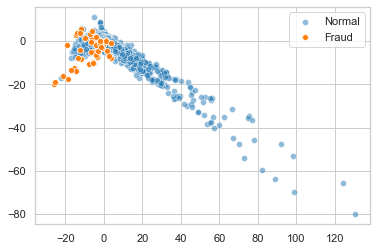

In [157]:
X_enc = encoder.predict(X_val)
X_enc_normal = X_enc[y_val==0]
X_enc_fraud = X_enc[y_val==1]
sns.scatterplot(x = X_enc_normal[:,0], y = X_enc_normal[:,1] ,label='Normal', alpha=0.5)
sns.scatterplot(x = X_enc_fraud[:,0], y = X_enc_fraud[:,1] ,label='Fraud')

In [159]:
X_out = autoencoder.predict(X_val)
print(X_out.shape)

(36176, 6)


In [160]:
X_val.shape

(36176, 6)

In [161]:
distances = np.sum((X_out-X_val)**2,axis=1)

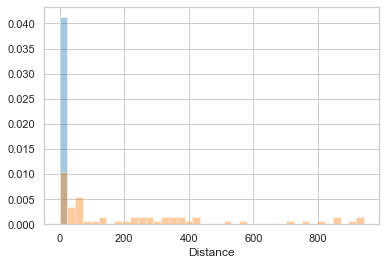

In [162]:
bins = np.linspace(0,np.max(distances),40)
sns.distplot(distances[y_val==0],label='Normal',kde=False, 
             bins=bins, norm_hist=True, axlabel='Distance')
sns.distplot(distances[y_val==1],label='Fraud',kde=False, bins=bins, norm_hist=True)

(0, 100)

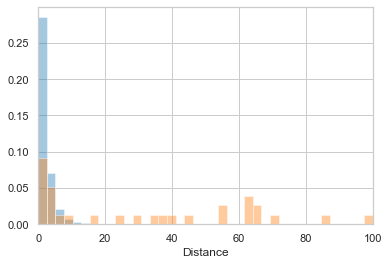

In [163]:
bins = np.linspace(0,100,40)
sns.distplot(distances[y_val==0],label='Normal',kde=False, 
             bins=bins, norm_hist=True, axlabel='Distance')
sns.distplot(distances[y_val==1],label='Fraud',kde=False, bins=bins, norm_hist=True)
plt.xlim((0,100))

## Validating the model

In [51]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [69]:
cv = StratifiedShuffleSplit(n_splits=VAL_SPLITS,test_size=0.15,random_state=0)



F1 value (Val): 0.79 ± 0.04
